# Car Price prediction

**Цель проекта** - предсказать цену автомобиля

**Задачи:** 
 - Написать программу по сбору данных об автомобилях с сайта auto.ru и выгрузить эти данные
 - Подготовить набор данных для обучения модели
 - Потренировать работу с pandas на реальных данных
 - Попрактиковаться в предобработке различных данных, в частности с пропущенными данными (Nan) и с различными видами кодирования признаков
 - Попрактиковаться в Feature Engineering
 - Попрактиковаться в построении различных моделях, в частности ансамбля алгоритмов


# 1. Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import math
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import fbeta_score, make_scorer

from datetime import datetime, timedelta
from tqdm.notebook import tqdm

from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from itertools import combinations
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Уберем Warnings из отображения
import warnings; warnings.simplefilter('ignore')

# Поправим отображение дасетов
pd.set_option('display.max_columns', None)

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

**МЕТРИКА**

Определим метрику для проверки моделей - MAPE  (Mean Percentage Absolute Error, расшифровывается выражение как средняя абсолютная ошибка в процентах).

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# 2. Setup

In [6]:
VERSION    = 19 # версия запуска для сохранения ответов

DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-10072021/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
FILE_TRAIN = 'all_auto_ru_10_07_2021.csv'
FILE_TEST  = 'test.csv'
FILE_SUB   =  'sample_submission.csv'

VAL_SIZE   = 0.20   # 20% для разделения выборки на обучающую и тестовую

# 3. Data

In [7]:
def load_data_frames():
    # Выгружает три датасета
    train = pd.read_csv(DIR_TRAIN + FILE_TRAIN)
    test = pd.read_csv(DIR_TEST + FILE_TEST)
    sample_submission = pd.read_csv(DIR_TEST + FILE_SUB)
    
    return train, test, sample_submission

In [8]:
train, test, sample_submission = load_data_frames()

In [9]:
train.sample(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,vehicleConfiguration,enginePower,description,mileage,Привод,Руль,Владельцы,ПТС,Таможня,Владение,price,model,vendor,equipment_dict,complectation_dict
34164,Внедорожник 5 дв.,NISSAN,97948F,бензин,2013.0,2.0 CVT (144 л.с.),5.0,2017,VARIATOR,CVT,ALLROAD_5_DOORS VARIATOR CVT,144.0,ОДИН ВЛАДЕЛЕЦ\nКРУИЗ КОНТРОЛЬ!!!..... ОБОГРЕВ ...,54959,передний,LEFT,1.0,ORIGINAL,True,NaN,1650000.0,X_TRAIL,JAPANESE,"{'cruise-control': True, 'airbag-driver': True...",{'id': '0'}
50372,Минивэн,VOLKSWAGEN,007F00,бензин,2003.0,2.0 MT (115 л.с.),5.0,2006,MECHANICAL,MT,MINIVAN MECHANICAL MT,115.0,"Двигатель контрактный,не оформлен.Родной есть ...",170000,передний,LEFT,2.0,ORIGINAL,True,"{'year': 2020, 'month': 9}",900000.0,MULTIVAN,EUROPEAN,"{'navigation': True, 'ptf': True, 'abs': True,...",{'id': '0'}


In [10]:
test.sample(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
31337,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s80/11013...,чёрный,NaN,Продам самый безопасный автомобиль Вольво s80 ...,2.4 LTR,170 N12,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,195000,2003,"{""code"":""S80"",""name"":""S80"",""ru_name"":""S80"",""mo...",S80,2.4 AT (170 л.с.),4,1603584798,RUB,2006,1101338578,"{""id"":""6502924"",""displacement"":2435,""engine_ty...",SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
657,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,NaN,Владею автомобилем с марта 2017 год...,1.8 LTR,152 N12,"{""engine-proof"":true,""tinted-glass"":true,""esp""...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,149000,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603228782,RUB,2012,1100143428,"{""id"":""8556154"",""displacement"":1798,""engine_ty...",WAGON_5_DOORS AUTOMATIC 1.8,автоматическая,EUROPEAN,3 или более,3 года и 7 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52634 entries, 0 to 52633
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              52633 non-null  object 
 1   brand                 52634 non-null  object 
 2   color                 52634 non-null  object 
 3   fuelType              52634 non-null  object 
 4   modelDate             52633 non-null  float64
 5   name                  52633 non-null  object 
 6   numberOfDoors         52633 non-null  float64
 7   productionDate        52634 non-null  int64  
 8   vehicleTransmission   52633 non-null  object 
 9   engineDisplacement    52633 non-null  object 
 10  vehicleConfiguration  52633 non-null  object 
 11  enginePower           52633 non-null  float64
 12  description           51528 non-null  object 
 13  mileage               52634 non-null  int64  
 14  Привод                52633 non-null  object 
 15  Руль               

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Форматы данных в обучающем и тестовом датасетах немного отлючаются. Для того, чтобы объединить их приведем форматы к одному виду.

In [13]:
def rename_columns_train(train: pd.DataFrame) -> None: 
    # Переименуем названия признаков в train датасете
    train.columns = [
        'body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
        'number_of_doors', 'production_date', 'vehicle_transmission',
        'engine_displacement', 'vehicle_configuration', 'engine_power',
        'description', 'mileage', 'drive_type', 'wheel', 'owners', 'pts',
        'customs', 'ownership', 'price', 'model_name', 'vendor', 'equipment_dict',
        'complectation_dict'
    ]

In [14]:
def rename_columns_test(test: pd.DataFrame) -> None: 
    # Переименуем названия признаков в test датасете
    test.columns = [
        'body_type', 'brand', 'car_url', 'color', 'complectation_dict',
        'description', 'engine_displacement', 'engine_power', 'equipment_dict',
        'fuel_type', 'image', 'mileage', 'model_date', 'model_info', 'model_name',
        'name', 'number_of_doors', 'parsing_unixtime', 'price_currency',
        'production_date', 'sell_id', 'super_gen', 'vehicle_configuration',
        'vehicle_transmission', 'vendor', 'owners', 'ownership', 'pts',
        'drive_type', 'wheel', 'condition', 'customs'
    ]

In [15]:
# engineDisplacement

def search_engine_displacement(text: str) -> float:
    pattern = '\d\.\d'
    match = re.findall(pattern, str(text))
    n = len(match)
    
    if n == 2:
        return float(match[1])
    elif n == 1:
        return float(match[0])
    else:
        return .0

In [16]:
def prepare_columns_format_train(train: pd.DataFrame) -> None: 
    # 1. Поле color в train представлено в виде hex_code
    color_hex_dict = {
        '040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', '0000CC': 'синий', 
        '007F00': 'зелёный', '200204': 'красный', 'CACECB': 'серебристый', '660099': 'фиолетовый', 
        'C49648': 'оранжевый', '22A0F8': 'голубой', 'DEA522': 'оранжевый', '4A2197': 'фиолетовый', 
        'FF8649': 'оранжевый', 'FFD600': 'жёлтый', 'FFC0CB': 'розовый', 'EE1D19': 'красный'
    }
    train.loc[:, 'color'] = train['color'].apply(lambda x: color_hex_dict[x])
    
    # 2. Владельцы меняем в train
    train.loc[:, 'owners'] = train['owners'].apply(lambda x: 3 if x > 3 else x)
    
    # 3. engineDisplacement
    train.loc[:, 'engine_displacement'] = train['name'].apply(search_engine_displacement)
    
    # 4. время парсинга 2021-07-10 02:07:00 - 1625882847
    train.loc[:, 'parsing_unixtime'] = 1625882847

In [17]:
def prepare_columns_format_test(test:  pd.DataFrame) -> None:
    # 1. Поле engine_power в test представлено в виде "306 N12", нам надо только число Л.С.
    test.loc[:, 'engine_power'] = test['engine_power'].apply(lambda x: str(x).split(' ')[0])
    
    # 2. wheel(Руль) 
    wheel_dict = {'Левый': 'LEFT', 'Правый': 'RIGHT'}
    test.loc[:, 'wheel'] = test['wheel'].apply(lambda x: wheel_dict[x])
    
    # 3. ПТС
    pts_dict = {'Оригинал': 'ORIGINAL', 'Дубликат': 'DUPLICATE'}
    test.loc[:, 'pts'] = test['pts'].apply(lambda x: pts_dict[x] if x == x else None)
    
    # 4. Владельцы меняем в test
    test.loc[:, 'owners'] = test['owners'].apply(lambda x: float(x[:1]))
    
    # 5. vehicleTransmission меняем в test
    vehicle_transmission_dict = {
        'автоматическая': 'AUTOMATIC', 'роботизированная': 'ROBOT', 
        'механическая': 'MECHANICAL', 'вариатор': 'VARIATOR'
    }
    test.loc[:, 'vehicle_transmission'] = test['vehicle_transmission'].apply(lambda x: vehicle_transmission_dict[x])
    
    # 6. engineDisplacement
    test.loc[:, 'engine_displacement'] = test['engine_displacement'].apply(search_engine_displacement)

In [18]:
def concatenate_data_frames(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
    columns = [
        'body_type', 'brand', 'color', 'fuel_type', 'mileage', 'model_date', 
        'name', 'number_of_doors', 'engine_power', 'wheel', 'drive_type', 'pts', 
        'owners', 'vehicle_transmission', 'production_date', 'vendor',
        'model_name', 'engine_displacement', 'ownership', 'complectation_dict', 
        'equipment_dict', 'parsing_unixtime'
    ]
    # 'ownership' - надо вытаскивать данные (количество месяцев владения)
    # 'complectation_dict' - надо вытаскивать данные
    # 'equipment_dict' - надо вытаскивать данные
    
    df_train = train[columns]
    df_test = test[columns]

    df_train['price'] = train['price']  # Целевая переменная трейна
    df_test['price'] = 0                # Целевой переменной теста нет, поэтому занулим пока
    
    df_train['sample'] = 1 # помечаем где у нас трейн
    df_test['sample'] = 0  # помечаем где у нас тест

    return df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [19]:
# Загрузим данные
train, test, sample_submission = load_data_frames()

# Согласуем наименования признаков
rename_columns_train(train)
rename_columns_test(test)

# Согласуем форматы признаков
prepare_columns_format_train(train)
prepare_columns_format_test(test)

# Объединим датасеты в один
data = concatenate_data_frames(train, test)

In [20]:
data.sample(5)

,body_type,brand,color,fuel_type,mileage,model_date,name,number_of_doors,engine_power,wheel,drive_type,pts,owners,vehicle_transmission,production_date,vendor,model_name,engine_displacement,ownership,complectation_dict,equipment_dict,parsing_unixtime,price,sample
35470,Внедорожник 5 дв.,AUDI,синий,дизель,80000,2015.0,3.0d AT (249 л.с.) 4WD,5.0,249,LEFT,полный,ORIGINAL,3.0,AUTOMATIC,2016,EUROPEAN,Q7,3.0,NaN,"{'id': '20943657', 'name': 'Comfort', 'availab...","{'cruise-control': True, 'asr': True, 'tinted-...",1625882847,3250000.0,1
67477,Внедорожник 5 дв.,NISSAN,чёрный,бензин,0,2017.0,1.2 MT (115 л.с.),5.0,115,LEFT,передний,ORIGINAL,NaN,MECHANICAL,2021,JAPANESE,QASHQAI,1.2,NaN,"{'id': '22506702', 'name': 'SE+', 'available_o...","{'cruise-control': True, 'asr': True, 'esp': T...",1625882847,1738000.0,1
11169,внедорожник 5 дв.,NISSAN,серый,бензин,91000,2014.0,2.0 AT (135 л.с.),5.0,135,LEFT,передний,ORIGINAL,3.0,AUTOMATIC,2014,JAPANESE,TERRANO,2.0,NaN,NaN,"{""engine-proof"":true,""alloy-wheel-disks"":true,...",1603269753,0.0,0
54870,Седан,MERCEDES,чёрный,бензин,148000,2005.0,500 5.5 AT (388 л.с.) 4WD,4.0,388,LEFT,полный,DUPLICATE,3.0,AUTOMATIC,2008,EUROPEAN,S_KLASSE,5.5,NaN,{'id': '0'},"{'asr': True, 'tinted-glass': True, 'roller-bl...",1625882847,1099000.0,1
39196,Внедорожник 5 дв.,BMW,синий,бензин,37362,2013.0,35i 3.0 AT (306 л.с.) 4WD,5.0,306,LEFT,полный,ORIGINAL,1.0,AUTOMATIC,2016,EUROPEAN,X5,3.0,NaN,"{'id': '21074304', 'name': 'xDrive35i Prestige...","{'cruise-control': True, 'esp': True, 'usb': T...",1625882847,3499000.0,1


# 4. Cleaning and Prepping Data

## Определим вспомогательные функции

In [21]:
def data_full_info(data, full=True, short=False):
    '''Функция для вывода общей информации по датасету.
    data - набор исходных данных
    full - флаг вывода информации для количественных признаков
    short - флаг вывода информации из первых трех строк датасета
    
    Функция для выводит общую информацию по датасету.
    
    Если установлен флаг short, то отобразить первые три строки из датасета.
    В ином случае - не отображать.
    
    
    Если установлен флаг full, то отобразить информацию для количественных признаков.
    В ином случае - не отображать.
    '''
        
    list_of_names = list(data.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = data.dtypes
    temp_dict['# значений'] = data.describe(include='all').loc['count'].astype(int)
    temp_dict['# пропусков(NaN)'] = data.isnull().sum().values 
    temp_dict['# уникальных'] = data.nunique().values
    
    if not short:
        temp_dict['в первой строке'] =data.loc[0].values
        temp_dict['во второй строке'] = data.loc[1].values
        temp_dict['в третьей строке'] = data.loc[2].values
        
    if full :
        temp_dict['минимум'] = data.describe(include='all').loc['min']
        temp_dict['среднее'] = data.describe(include='all').loc['mean']
        temp_dict['макс'] = data.describe(include='all').loc['max']
        temp_dict['медиана'] = data.describe(include='all').loc['50%']
        
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return

In [22]:
def column_info(data: pd.DataFrame, column: str) -> None:
    '''Функция для вывода информации для номинативных признаков.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений номинативного признака и выводит их в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    print(f'Проведем анализ для переменной {column}')
    
    print('Тип данных: ', data[column].dtype)
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    print(f'Значений, упомянутых более {n} раз:', (data[column].value_counts() > n).sum())
    print('Уникальных значений:', data[column].nunique())
      
    display(pd.DataFrame(data[column].value_counts()).head(10))
    

def plot_column_info(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений и значениий ограниченных границами выбросов IQR.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR

    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'

    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    
    plt.rcParams['figure.figsize'] = (10,7)
    
    data[column].loc[data[column].between(lower_limt, upper_limit)].hist(bins=20,
                                                                         range=(min_value, max_value), 
                                                                         label='IQR')

    data[column].hist(alpha=0.5, 
                      bins=20, 
                      range=(min_value, max_value), 
                      label='Исходные значения')

    plt.legend();

In [23]:
def plot_column_info_log(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений, boxplot исходных значений, гистограмму логарифма исходных значений 
    и boxplot для них.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR
    
    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'
    
    outliers_num = data.query(f'{column} < {lower_limt} or {column} > {upper_limit}').shape[0]
    
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    print('Количество выбросов:', outliers_num)
    
    plt.rcParams['figure.figsize'] = (12,4)
    
    ser_iqr = data[column].loc[data[column].between(lower_limt, upper_limit)]
    ser_act = data[column]
    ser_log = data[column].apply(lambda x: math.log(x + 1))
    
    fig = plt.figure()
    st = fig.suptitle(f'Гистограммы и box-plot для признака \'{column}\' и log(\'{column}\')', fontsize='x-large')
    
    ax_1 = fig.add_subplot(1, 4, 1)
    ax_2 = fig.add_subplot(1, 4, 2)
    ax_3 = fig.add_subplot(1, 4, 3)
    ax_4 = fig.add_subplot(1, 4, 4)
    
    ax_1.hist(ser_act, bins=15)
    ax_1.set_title(f'\'{column}\'', loc = 'right', fontsize=10)
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
    ax_2.boxplot(ser_act)
    ax_2.set_title(f'boxplot of \'{column}\'', loc = 'left', fontsize=10)
    ax_2.spines['top'].set_visible(False)
    ax_2.spines['right'].set_visible(False)
    ax_2.spines['bottom'].set_visible(False)
    ax_2.spines['left'].set_visible(False)
    
    ax_3.hist(ser_log, bins=15)
    ax_3.set_title(f'log(\'{column}\')', loc = 'right', fontsize=10)
    ax_3.spines['top'].set_visible(False)
    ax_3.spines['right'].set_visible(False)
    
    ax_4.boxplot(ser_log)
    ax_4.set_title(f'boxplot of log(\'{column}\')', loc = 'left', fontsize=10)
    ax_4.spines['top'].set_visible(False)
    ax_4.spines['right'].set_visible(False)
    ax_4.spines['bottom'].set_visible(False)
    ax_4.spines['left'].set_visible(False)
    
    
    # shift subplots down:
    st.set_y(0.99)
    fig.subplots_adjust(top=0.85)
    
    plt.legend()
    plt.show();

In [24]:
def replace_nan(data_in: pd.DataFrame, column: str, typ: str, new_value='') -> pd.DataFrame:
    '''Функция возвращает датасет, в котором произведена замена пустых значений признака и добавлен новый
    признак, в котором сохраняется информаця о том, в какой строке было пустое значение
    data_in - набор исходных данных
    column - наименование признака
    typ - тип замены, может принимать значения: 'mode', 'median', 'mean', 'new_value'
    
    Создается новый признак с наименованием (column)_isnan, в котором сохраняется информаця 
    о том, в какой строке пустое значение признака (column)
    В зависимости от типа замены (typ) функция определяет значение, 
    на которое будет производится замена.
    Все значения признака (column) в наборе данных (data_in) заменяются на вычисленное значение.
    Функция возращает откорректированный набор данных, изменений в исходном наборе нет.
    
    '''
    
    data = data_in.copy()
    
    print(f'В новый признак \'{column}_isnan\' охраняем информацию, в каком наблюдении указано NaN')
    data.loc[:, column + '_isnan'] = pd.isna(data[column]).astype('uint8')
    
    if typ == 'mode':
        m = data.loc[:, column].mode()[0]
        s = 'самым распространенным значением '
    elif typ == 'median':
        m = data.loc[:, column].median()
        s = 'медианой'
    elif typ == 'mean':
        m = data.loc[:, column].mean()
        s = 'средневзвешенным значением'
    elif typ == 'new_value':
        m = new_value
        s = 'указанным значением'
    else:
        return None
    
    print(f'Заполним пустые значения признака {column} {s} {m}')
    data.loc[:, column] = data[column].fillna(m)
    
    return data

In [25]:
def all_metrics(d_y_true, d_y_pred, d_y_pred_prob):
        
    temp_dict = {}
    temp1 = accuracy_score(d_y_true, d_y_pred)
    temp_dict['accuracy'] = [temp1, '(TP+TN)/(P+N)']

    temp1 = balanced_accuracy_score(d_y_true, d_y_pred)
    temp_dict['balanced accuracy'] = [temp1, 'сбалансированная accuracy']
    
    temp1 = precision_score(d_y_true, d_y_pred)
    temp_dict['precision'] = [temp1, 'точность = TP/(TP+FP)']
    
    temp1 = recall_score(d_y_true, d_y_pred)
    temp_dict['recall'] = [temp1, 'полнота = TP/P']
    
    temp1 = f1_score(d_y_true, d_y_pred)
    temp_dict['f1_score'] = [temp1, 'среднее гармоническое точности и полноты']
    
    temp1 = roc_auc_score(d_y_true, d_y_pred_prob)
    temp_dict['roc_auc'] = [temp1, 'Area Under Curve - Receiver Operating Characteristic']    
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Значение', 'Описание'])
    display(temp_df)

    return


def model_coef(d_columns, d_model_coef_0):

    temp_dict = {}
    temp_dict['имя признака'] = d_columns
    temp_dict['коэффициент модели'] = d_model_coef_0
    temp_dict['модуль коэф'] = abs(temp_dict['коэффициент модели'])
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
    temp_df = temp_df.sort_values(by='модуль коэф', ascending=False)
    temp_df.reset_index(drop=True,inplace=True)
    
    return temp_df.loc[:,['имя признака','коэффициент модели']]

In [26]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    
    
def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, d_my_font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color= 'darkblue')
    plt.plot([0,num_folds-1], [avg_metric_train, avg_metric_train], color='blue', label='среднее трен. значений ', marker='.', lw=2, ls = '--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color= 'red')
    plt.plot([0,num_folds-1], [avg_metric_test, avg_metric_test], color='lightcoral', label='среднее тест. значений ', marker='.', lw=2, ls = '--')

    plt.plot([0,num_folds-1], [d_value_metric, d_value_metric], color='grey', label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train,avg_metric_test) + 1.5*max(std_metric_train,std_metric_test)
    y_min = min(avg_metric_train,avg_metric_test) - 3*max(std_metric_train,std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color = color_text)
    plt.ylabel(d_name_metric, fontsize=15, color = color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах', color = color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min +0.5*max(std_metric_train,std_metric_test)
    plt.text(0, y_min_text, f'{d_name_metric} на трейне = {round(avg_metric_train,3)} +/- {round(std_metric_train,3)} \n{d_name_metric} на тесте    = {round(avg_metric_test,3)} +/- {round(std_metric_test,3)} \n{d_name_metric} до CV        = {round(d_value_metric,3)}', fontsize = 15)
    plt.show()
    return

In [27]:
# Класс-помощник для красивого отображения данных о модели. Взял у https://www.kaggle.com/ekalachev
class ModelInspector():
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y

    def _plot_confusion_matrix(self, y_pred, ax):
        tn, fp, fn, tp = confusion_matrix(self.y, y_pred).ravel()

        matrix = np.eye(2)
        matrix_annot = [[f'TP\n{tp}', f'FP\n{fp}'], [f'FN\n{fn}', f'TN\n{tn}']]

        sns.heatmap(matrix, annot=matrix_annot, annot_kws={"size": 20}, fmt='', cmap='Greens', cbar=False,
                    xticklabels=['', 'Good client'], yticklabels=['Bad client', ''], ax=ax)

    def _plot_metrics(self, y_pred, roc_auc, ax):
        matrix = np.array([[1, 0, 1, 0, 1]]).T

        matrix_annot = np.array([[
            f'ROC AUC: {roc_auc:.4f}',
            f'Balanced accuracy: {balanced_accuracy_score(self.y, y_pred):.3f}',
            f'F1-score: {f1_score(self.y, y_pred):.3f}',
            f'Precision score: {precision_score(self.y, y_pred):.3f}',
            f'Recall score: {recall_score(self.y, y_pred):.3f}'
        ]]).T

        sns.heatmap(matrix, annot=matrix_annot, fmt='', cbar=False, yticklabels=[],
                    xticklabels=[], annot_kws={'size': 16, 'ha': 'center'}, cmap='GnBu', ax=ax)

    def _plot_logistic_regression(self, probs, ax):
        fpr, tpr, threshold = roc_curve(self.y, probs)

        ax.plot([0, 1], label='Baseline', linestyle='--')
        ax.plot(fpr, tpr, label='Regression')
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.legend(loc='lower right')

    def inspect(self, size=5):
        y_pred = self.model.predict(self.X)
        probs = self.model.predict_proba(self.X)[:, 1]
        roc_auc = roc_auc_score(self.y, probs)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig.suptitle(f'Model inspection. ROC AUC: {roc_auc:.4f}', fontsize=20)

        ax1.set_title('Logistic Regression')
        ax2.set_title('Confusion matrix')
        ax3.set_title('Metrics')

        # Plot logistic regression
        self._plot_logistic_regression(probs, ax1)

        # Plot confusion matrix
        self._plot_confusion_matrix(y_pred, ax2)

        # plot metrics
        self._plot_metrics(y_pred, roc_auc, ax3)

        plt.show()

In [28]:
def get_stat_dif(data: pd.DataFrame, column: str, target: str) -> bool:
    '''Функция определяет, есть ли статистически значимые различия для признака.
    data - набор исходных данных
    column - наименование признака
    target - наименование целевого признака
    
    Функция проверяет, есть ли статистическая разница в распределении целевого признака (target)
    по номинативному признаку (column) в наборе данных (data). 
    Проверка осуществляется с помощью теста Стьюдента. 
    Проверяется нулевая гипотеза о том, что распределения целевого признака (target)
    по различным парам значений номинативного признака (column) неразличимы.
    Пары определяются из различных комбинаций n самых часто встречающихся занчений признака (column).
    Если различия найдены, то информация об этом выводится в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    cols = data.loc[:, column].value_counts().index[:n]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], target], 
                     data.loc[data.loc[:, column] == comb[1], target]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для признака', column)
            return True
    
    return False

## Проведем предварительный анализ данных

In [29]:
# Выведем общую информацию по датасету
data_full_info(data, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,body_type,object,87319,1,118,NaN,NaN,NaN,NaN
1,brand,object,87320,0,12,NaN,NaN,NaN,NaN
2,color,object,87320,0,16,NaN,NaN,NaN,NaN
3,fuel_type,object,87320,0,6,NaN,NaN,NaN,NaN
4,mileage,int64,87320,0,21957,0,125101,1e+06,114054
5,model_date,float64,87319,1,67,1904,2010.02,2021,2011
6,name,object,87319,1,3342,NaN,NaN,NaN,NaN
7,number_of_doors,float64,87319,1,5,0,4.52793,5,5
8,engine_power,object,87319,1,628,NaN,NaN,NaN,NaN
9,wheel,object,87320,0,2,NaN,NaN,NaN,NaN


In [30]:
# Заведем 4 списка под разные  типы признаков
# Временные признаки 
time_cols = []

# Бинарные признаки 
bin_cols = []

# Категориальные признаки
cat_cols = []

# Колличественные признаки 
num_cols = []

# Лишние признаки
del_cols = []

# целевые признаки
target_cols = []

Признак **body_type**

In [31]:
column_info(data, 'body_type')

Проведем анализ для переменной body_type
Тип данных:  object
Всего значений: 87320
Пустых значений: 1
Значений, упомянутых более 10 раз: 53
Уникальных значений: 118


,body_type
Внедорожник 5 дв.,26425
Седан,13960
седан,13147
внедорожник 5 дв.,12228
Лифтбек,3231
лифтбек,2232
хэтчбек 5 дв.,2124
Хэтчбек 5 дв.,1841
Седан Long,1443
универсал 5 дв.,1276


In [32]:
# Посмотрим на объек с пустым полем в body_type
data.query('body_type != body_type')

,body_type,brand,color,fuel_type,mileage,model_date,name,number_of_doors,engine_power,wheel,drive_type,pts,owners,vehicle_transmission,production_date,vendor,model_name,engine_displacement,ownership,complectation_dict,equipment_dict,parsing_unixtime,price,sample
47660,NaN,HONDA,серебристый,универсал,400000,NaN,NaN,NaN,NaN,LEFT,NaN,ORIGINAL,3.0,NaN,1989,JAPANESE,CIVIC,0.0,NaN,"{'id': '0', 'name': ''}",{},1625882847,120000.0,1


In [33]:
# Выносим в блок предобработки

# Данный объект имеет очень много пропусков, в том числе и в полях model_date, name, number_of_doors, engine_power, drive_type, vehicle_transmission
# Удалим его
data.dropna(subset=['body_type'], inplace=True)

In [34]:
# Еще раз посмотрим общую информацию по датасету
data_full_info(data, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,body_type,object,87319,0,118,NaN,NaN,NaN,NaN
1,brand,object,87319,0,12,NaN,NaN,NaN,NaN
2,color,object,87319,0,16,NaN,NaN,NaN,NaN
3,fuel_type,object,87319,0,5,NaN,NaN,NaN,NaN
4,mileage,int64,87319,0,21957,0,125098,1e+06,114050
5,model_date,float64,87319,0,67,1904,2010.02,2021,2011
6,name,object,87319,0,3342,NaN,NaN,NaN,NaN
7,number_of_doors,float64,87319,0,5,0,4.52793,5,5
8,engine_power,object,87319,0,628,NaN,NaN,NaN,NaN
9,wheel,object,87319,0,2,NaN,NaN,NaN,NaN


In [35]:
# Выносим в блок предобработки

# Приведем значения признака body_type к нижнему регистру
data.loc[:, 'body_type'] = data['body_type'].apply(lambda x: str(x).lower())

# отнесем признак к категориальным
cat_cols.append('body_type')

In [36]:
column_info(data, 'body_type')

Проведем анализ для переменной body_type
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 39
Уникальных значений: 94


,body_type
внедорожник 5 дв.,38653
седан,27107
лифтбек,5463
хэтчбек 5 дв.,3965
универсал 5 дв.,2380
купе,1893
минивэн,1700
седан long,1443
хэтчбек 3 дв.,894
компактвэн,832


Пока оставим данный признак так. 

**Идея на будущее:** можно оставить только внедорожник, седан, лифтбек и т.д. без доп.информации

Признак **'brand'**

In [37]:
column_info(data, 'brand')

Проведем анализ для переменной brand
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 12
Уникальных значений: 12


,brand
MERCEDES,16955
BMW,12680
VOLKSWAGEN,10304
NISSAN,9361
TOYOTA,7886
AUDI,7644
MITSUBISHI,6482
SKODA,6350
VOLVO,3418
LEXUS,2523


In [38]:
# отнесем признак к категориальным
cat_cols.append('brand')

Все хорошо. Оставляем признак как есть.

Признак **'color'**

In [39]:
column_info(data, 'color')

Проведем анализ для переменной color
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 16
Уникальных значений: 16


,color
чёрный,28484
белый,16874
серый,11110
синий,8638
серебристый,8305
красный,5566
зелёный,2217
коричневый,1501
оранжевый,1417
голубой,943


In [40]:
# отнесем признак к категориальным
cat_cols.append('color')

Все хорошо. Оставляем признак как есть.

Признак **'pts'**

In [41]:
column_info(data, 'pts')

Проведем анализ для переменной pts
Тип данных:  object
Всего значений: 87319
Пустых значений: 271
Значений, упомянутых более 10 раз: 2
Уникальных значений: 3


,pts
ORIGINAL,77565
DUPLICATE,9483


In [42]:
# Выносим в блок предобработки

# Есть пустые значения. Заполняем пустые значения самым распространенным значением
data = replace_nan(data, 'pts', 'mode')

В новый признак 'pts_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака pts самым распространенным значением  ORIGINAL


In [43]:
# отнесем признак к бинарным
bin_cols.append('pts_isnan')

In [44]:
column_info(data, 'pts')

Проведем анализ для переменной pts
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,pts
ORIGINAL,77836
DUPLICATE,9483


In [45]:
# Преобразуем education в целочисленный формат. 
pts_dict = {'ORIGINAL': 1, 'DUPLICATE': 0}
data.loc[:, 'pts'] = data['pts'].map(pts_dict)

In [46]:
# отнесем признак к бинарным
bin_cols.append('pts')

Все хорошо. Оставляем признак как есть.

Признак **'fuel_type'**

In [47]:
column_info(data, 'fuel_type')

Проведем анализ для переменной fuel_type
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,fuel_type
бензин,67741
дизель,18885
гибрид,500
электро,181
газ,12


In [48]:
# отнесем признак к категориальным
cat_cols.append('fuel_type')

Все хорошо. Оставляем признак как есть.

Признак **'mileage'**

Всего значений: 87319
Пустых значений: 0
25-й перцентиль: 16285.0, 75-й перцентиль: 191500.0, IQR: 175215.0,
Границы значений: [0, 1000000],
Границы выбросов: [-246537.5, 454322.5].
Есть выбросы.
Количество выбросов: 721


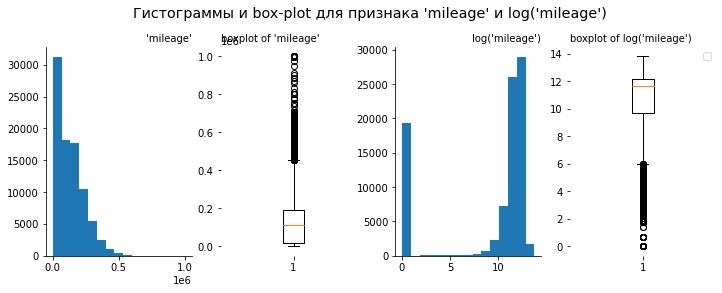

In [49]:
plot_column_info_log(data, 'mileage')

In [50]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'mileage'] = np.log(data['mileage'] + 1)

# Добавим новый признак 'is_new' Новая машина или б/у
data.loc[:, 'is_new'] = data['mileage'].apply(lambda x: 0 if x > 0 else 1)

С выбросами пока ничего не делаем

In [51]:
# отнесем признак к количественным
num_cols.append('mileage')

# отнесем признак к бинарным
bin_cols.append('is_new')

Признак **'model_date'**

Всего значений: 87319
Пустых значений: 0
25-й перцентиль: 2006.0, 75-й перцентиль: 2017.0, IQR: 11.0,
Границы значений: [1904.0, 2021.0],
Границы выбросов: [1989.5, 2033.5].
Есть выбросы.


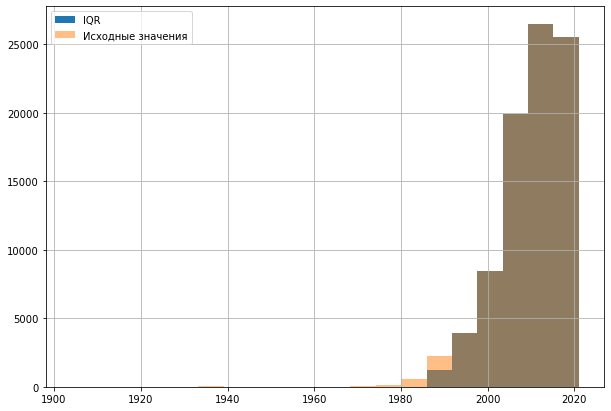

In [52]:
plot_column_info(data, 'model_date')

С выбросами пока ничего не делаем. Автомобили с таким ранним годом выпуска возможны.

In [53]:
# отнесем признак к количественным, можно было бы и к временным, но пока не вижу смысла
num_cols.append('model_date')

Все хорошо. Оставляем признак как есть.

Признак **'name'**

Данный признаак составной. Основная информация содержится в признаках 'engine_displacement', 'vehicle_transmission', 'engine_power', 'drive_type'.
В некоторых случаях еще дополнительно указывают модель двигателся и модель коробки передач

In [54]:
# посмотрим на признак
data[['name', 'engine_displacement', 'vehicle_transmission', 'engine_power', 'drive_type']].sample(10)

,name,engine_displacement,vehicle_transmission,engine_power,drive_type
2608,2.0 AMT (170 л.с.) 4WD,2.0,ROBOT,170,полный
25669,1.4 AMT (122 л.с.),1.4,ROBOT,122,передний
52802,220 d 2.0d AT (194 л.с.) 4WD,2.0,AUTOMATIC,194,полный
38996,40i 3.0 AT (340 л.с.) 4WD,3.0,AUTOMATIC,340,полный
54920,450 Long 3.0 AT (367 л.с.) 4WD,3.0,AUTOMATIC,367,полный
77387,4.5d AT (235 л.с.) 4WD,4.5,AUTOMATIC,235,полный
58980,450 3.0 AT (367 л.с.) 4WD,3.0,AUTOMATIC,367,полный
54639,560 4MATIC 4.0 AT (469 л.с.) 4WD,4.0,AUTOMATIC,469,полный
71856,1.5 AT (105 л.с.),1.5,AUTOMATIC,105,передний
60639,320 3.0d AT (224 л.с.) 4WD,3.0,AUTOMATIC,224,полный


Уберем признак.

**Идея на будущее:** можно добавить два признака - модель двигателся и модель коробки передач

In [55]:
# Уберем признак.
del_cols.append('name')

Признак **'number_of_doors'**

Всего значений: 87319
Пустых значений: 0
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,
Границы значений: [0.0, 5.0],
Границы выбросов: [2.5, 6.5].
Есть выбросы.
Количество выбросов: 2674


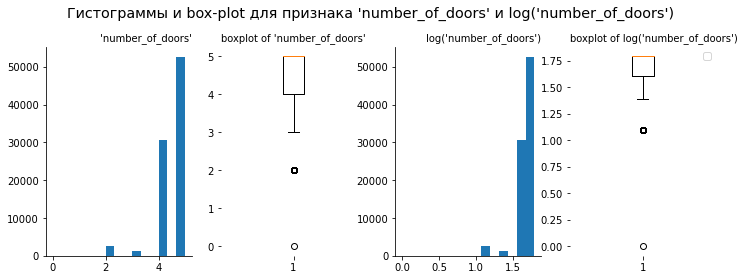

In [56]:
plot_column_info_log(data, 'number_of_doors')

In [57]:
# отнесем признак к количественным
num_cols.append('number_of_doors')

Все хорошо. Оставляем признак как есть.

Признак **'engine_power'**

In [58]:
column_info(data, 'engine_power')

Проведем анализ для переменной engine_power
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 432
Уникальных значений: 628


,engine_power
249.0,5567
150.0,4262
190.0,2456
110.0,2181
249,1708
245.0,1705
150,1699
184.0,1597
197.0,1359
144.0,1338


In [59]:
# Выносим в блок предобработки

# приведем к формату int
data.loc[:, 'engine_power'] = data['engine_power'].astype('int')

Всего значений: 87319
Пустых значений: 0
25-й перцентиль: 140.0, 75-й перцентиль: 249.0, IQR: 109.0,
Границы значений: [30, 800],
Границы выбросов: [-23.5, 412.5].
Есть выбросы.
Количество выбросов: 2859


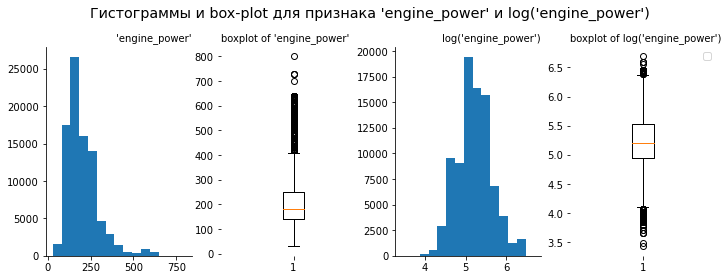

In [60]:
plot_column_info_log(data, 'engine_power')

In [61]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'engine_power'] = np.log(data['engine_power'] + 1)

In [62]:
# отнесем признак к количественным
num_cols.append('engine_power')

Все хорошо. С выбросами ничего не делаем, так как машины с мощностью двигателя выше 412 л.с. и до 800 л.с. вполне могут быть.

Признак **'wheel'**

In [63]:
column_info(data, 'wheel')

Проведем анализ для переменной wheel
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,wheel
LEFT,84687
RIGHT,2632


In [64]:
# Преобразуем wheel в целочисленный формат. 
wheel_dict = {'LEFT': 1, 'RIGHT': 0}
data.loc[:, 'wheel'] = data['wheel'].map(wheel_dict)

In [65]:
# отнесем признак к бинарным
bin_cols.append('wheel')

С признаком все хорошо. Оставляем как есть.

Признак **'drive_type'**

In [66]:
column_info(data, 'drive_type')

Проведем анализ для переменной drive_type
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 3
Уникальных значений: 3


,drive_type
полный,45435
передний,33078
задний,8806


In [67]:
# отнесем признак к категориальным
cat_cols.append('drive_type')

С признаком все хорошо. Оставляем как есть.

Признак **'owners'**

Всего значений: 87319
Пустых значений: 19351
25-й перцентиль: 1.0, 75-й перцентиль: 3.0, IQR: 2.0,
Границы значений: [1.0, 3.0],
Границы выбросов: [-2.0, 6.0].
Выбросов Нет.
Количество выбросов: 0


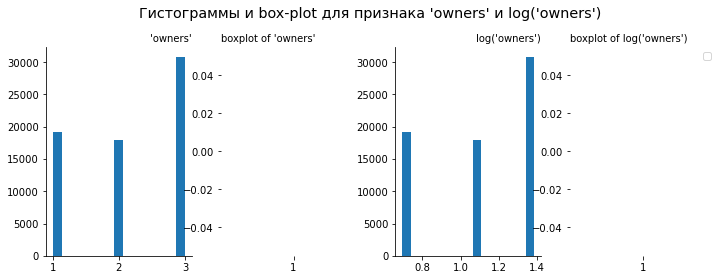

In [68]:
plot_column_info_log(data, 'owners')

In [69]:
# В поле Владельцы есть много пропусков. Но по большей части пропуски указаны для машин с нулевым пробегом
data.query('owners != owners')['mileage'].value_counts()

0.000000     19349
12.254868        1
11.482477        1
Name: mileage, dtype: int64

In [70]:
# Вынесем в блок предобработки

# Заполним пропуски в поле owners 0, если проьег нулевой.
data.loc[data.query('owners != owners and mileage == 0').index, 'owners'] = 0

# Заполним пропуски в поле owners медианным значением
data = replace_nan(data, 'owners', 'median')

В новый признак 'owners_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака owners медианой 2.0


In [71]:
# отнесем признак к количественным
num_cols.append('owners')

# новый признак owners_isnan отнесем к бинарным
bin_cols.append('owners_isnan')

С признаком все хорошо. Оставляем как есть.

Признак **'vehicle_transmission'**

In [72]:
column_info(data, 'vehicle_transmission')

Проведем анализ для переменной vehicle_transmission
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,vehicle_transmission
AUTOMATIC,52630
MECHANICAL,14190
ROBOT,10608
VARIATOR,9891


In [73]:
# отнесем признак к категориальным
cat_cols.append('vehicle_transmission')

С признаком все хорошо. Оставляем как есть.

Признак **'production_date'**

Всего значений: 87319
Пустых значений: 0
25-й перцентиль: 2008.0, 75-й перцентиль: 2019.0, IQR: 11.0,
Границы значений: [1904, 2021],
Границы выбросов: [1991.5, 2035.5].
Есть выбросы.


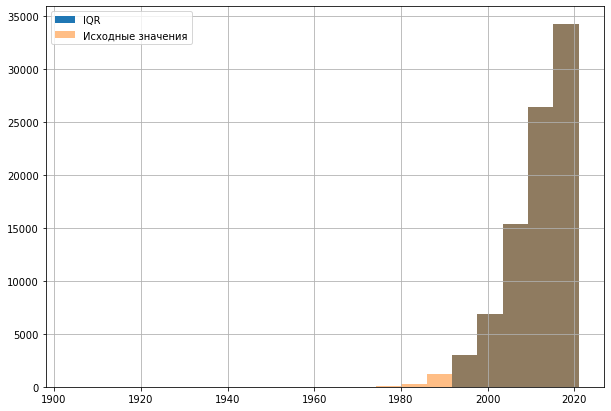

In [74]:
plot_column_info(data, 'production_date')

In [75]:
# отнесем признак к количественным. можно было бы и к временным, но пока не вижу смысла
num_cols.append('production_date')

С признаком все хорошо. Оставляем как есть.

Признак **'vendor'**

In [76]:
column_info(data, 'vendor')

Проведем анализ для переменной vendor
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 3


,vendor
EUROPEAN,57350
JAPANESE,29968
AMERICAN,1


In [77]:
# Посмотрим на выделяющуюся машину из Америки
model_name = data.query('vendor == "AMERICAN"')['model_name'].values[0]
data.query(f'model_name == "{model_name}"')

,body_type,brand,color,fuel_type,mileage,model_date,name,number_of_doors,engine_power,wheel,drive_type,pts,owners,vehicle_transmission,production_date,vendor,model_name,engine_displacement,ownership,complectation_dict,equipment_dict,parsing_unixtime,price,sample,pts_isnan,is_new,owners_isnan
23817,минивэн,VOLKSWAGEN,белый,бензин,12.345839,1997.0,2.8 AT (140 л.с.),4.0,4.948760,1,передний,0,3.0,AUTOMATIC,2002,EUROPEAN,EUROVAN,2.8,NaN,NaN,NaN,1603215210,0.0,0,0,0,0
24450,минивэн,VOLKSWAGEN,серебристый,бензин,12.374130,1997.0,2.8 AT (201 л.с.),4.0,5.308268,1,передний,1,2.0,AUTOMATIC,2001,EUROPEAN,EUROVAN,2.8,2 года и 2 месяца,NaN,"{""cruise-control"":true,""tinted-glass"":true,""ro...",1603217636,0.0,0,0,0,0
24498,минивэн,VOLKSWAGEN,чёрный,бензин,12.736704,1997.0,2.8 AT (201 л.с.),4.0,5.308268,1,передний,0,3.0,AUTOMATIC,2001,EUROPEAN,EUROVAN,2.8,NaN,NaN,"{""ptf"":true,""lock"":true}",1603217812,0.0,0,0,0,0
85301,минивэн,VOLKSWAGEN,красный,бензин,12.601491,1997.0,2.8 AT (201 л.с.),4.0,5.308268,1,передний,1,1.0,AUTOMATIC,2001,AMERICAN,EUROVAN,2.8,NaN,{'id': '0'},{},1625882847,650000.0,1,0,0,0


По всей видимости произошла ошибка при регистрации на сайте. Поправим значение признака на 'EUROPEAN'

In [78]:
# Вынесем в блок предобработки

# Поправим значение признака на 'EUROPEAN'
index = data.query('vendor == "AMERICAN"').index
data.loc[index, 'vendor'] = 'EUROPEAN'

In [79]:
column_info(data, 'vendor')

Проведем анализ для переменной vendor
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,vendor
EUROPEAN,57351
JAPANESE,29968


In [80]:
# Преобразуем vendor в целочисленный формат. 
vendor_dict = {'EUROPEAN': 1, 'JAPANESE': 0}
data.loc[:, 'vendor'] = data['vendor'].map(vendor_dict)

In [81]:
# отнесем признак к бинарным
bin_cols.append('vendor')

С признаком все хорошо. Оставляем как есть.

Признак **'model_name'**

In [82]:
column_info(data, 'model_name')

Проведем анализ для переменной model_name
Тип данных:  object
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 319
Уникальных значений: 544


,model_name
E_KLASSE,2848
OCTAVIA,2604
POLO,2318
5ER,2201
3ER,2069
S_KLASSE,1858
X5,1746
QASHQAI,1732
X_TRAIL,1723
X3,1721


In [83]:
# отнесем признак к категориальным
cat_cols.append('model_name')

С признаком все хорошо. Оставляем как есть.

Признак **'engine_displacement'**

Всего значений: 87319
Пустых значений: 0
25-й перцентиль: 1.8, 75-й перцентиль: 3.0, IQR: 1.2,
Границы значений: [0.0, 6.6],
Границы выбросов: [2.220446049250313e-16, 4.8].
Есть выбросы.
Количество выбросов: 2205


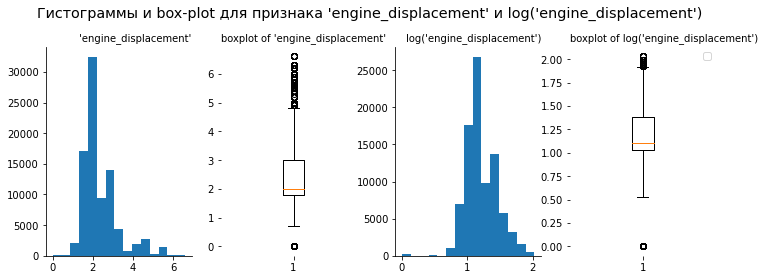

In [84]:
plot_column_info_log(data, 'engine_displacement')

In [85]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'engine_displacement'] = np.log(data['engine_displacement'] + 1)

In [86]:
# отнесем признак к количественным.
num_cols.append('engine_displacement')

Оставляем как есть. С выбросами ничего не делаем, 0 объем указан для электромобилей, что логично. Также есть машины с большим объемом двигателя (более 5 л.), это вполне реально, особенно для спорткаров или больших внедорожников.

Признак **'ownership'**

In [87]:
column_info(data, 'ownership')

Проведем анализ для переменной ownership
Тип данных:  object
Всего значений: 87319
Пустых значений: 64365
Значений, упомянутых более 10 раз: 306
Уникальных значений: 553


,ownership
"{'year': 2020, 'month': 11}",250
"{'year': 2021, 'month': 1}",234
"{'year': 2020, 'month': 10}",231
"{'year': 2020, 'month': 12}",225
"{'year': 2020, 'month': 8}",222
"{'year': 2020, 'month': 9}",221
1 год и 10 месяцев,209
2 года,197
1 год,194
1 год и 1 месяц,193


In [88]:
# Временно не будем рассматривать признаки 'ownership', 'complectation_dict', 'equipment_dict'

del_cols.append('ownership')
del_cols.append('complectation_dict')
del_cols.append('equipment_dict')

Рассмотрим признак **'parsing_unixtime'**

In [89]:
column_info(data, 'parsing_unixtime')

Проведем анализ для переменной parsing_unixtime
Тип данных:  int64
Всего значений: 87319
Пустых значений: 0
Значений, упомянутых более 10 раз: 1
Уникальных значений: 34687


,parsing_unixtime
1625882847,52633
1603113575,1
1603222130,1
1603215985,1
1603218032,1
1603241317,1
1603125869,1
1603127916,1
1603662259,1
1603300056,1


In [90]:
# Пустых значений нет. Переведем в формат времени
data.loc[:, 'parsing_unixtime'] = data['parsing_unixtime'].apply(lambda x: datetime.fromtimestamp(x))

In [91]:
# определим к временным признакам
time_cols.append('parsing_unixtime')

In [92]:
# Добавим новый признак 'usd_rub_rate_date' - курс доллара к рублю на момент выгрузки данных
usd_rub_rate_date = {
    '10.07.2021': 74.4675, '26.10.2020': 76.4667, '25.10.2020': 76.4667,
    '24.10.2020': 76.4667, '21.10.2020': 77.7780, '20.10.2020': 77.9241, '19.10.2020': 77.9644
}
data.loc[:, 'usd_rub_rate_date'] = data['parsing_unixtime'].dt.strftime('%d.%m.%Y').map(usd_rub_rate_date)

In [93]:
# отнесем признак к техническим, пометим как к удалению.
del_cols.append('usd_rub_rate_date')

Рассмотрим целевой признак **'price'**

Всего значений: 52633
Пустых значений: 210
25-й перцентиль: 800000.0, 75-й перцентиль: 4329000.0, IQR: 3529000.0,
Границы значений: [20000.0, 55000000.0],
Границы выбросов: [-4493500.0, 9622500.0].
Есть выбросы.
Количество выбросов: 3357


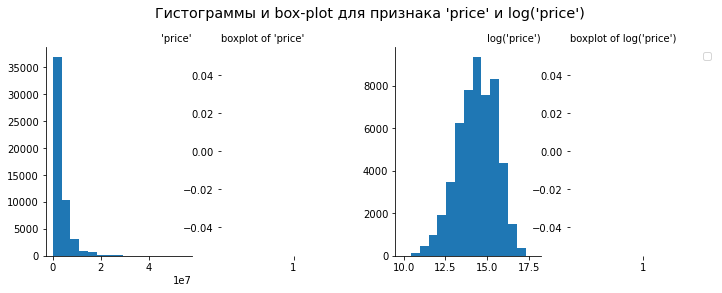

In [94]:
plot_column_info_log(data.query('sample == 1'), 'price')

In [95]:
# Выносим в блок предобработки

# Заполним пустые значения медианным значение для данной марки
index_nan_price = data.query('sample == 1 and price != price').index
median_price_model = data.query('sample == 1 and price == price').groupby('model_name')['price'].median()
data.loc[index_nan_price, 'price'] = data.loc[index_nan_price, 'model_name'].map(median_price_model)

Всего значений: 52633
Пустых значений: 0
25-й перцентиль: 800000.0, 75-й перцентиль: 4317000.0, IQR: 3517000.0,
Границы значений: [20000.0, 55000000.0],
Границы выбросов: [-4475500.0, 9592500.0].
Есть выбросы.
Количество выбросов: 3394


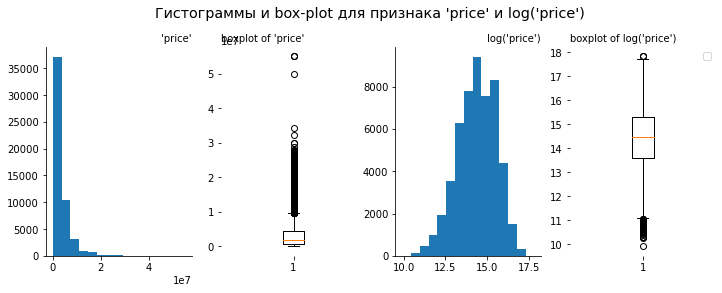

In [96]:
plot_column_info_log(data.query('sample == 1'), 'price')

In [97]:
# Выносим в блок предобработки

# Добавим новый признак - целевой признак в usd
data.loc[:, 'price_usd'] = data['price'] / data['usd_rub_rate_date']

Всего значений: 52633
Пустых значений: 0
25-й перцентиль: 10742.94155168362, 75-й перцентиль: 57971.59834827274, IQR: 47228.656796589115,
Границы значений: [268.5735387920905, 738577.2316782488],
Границы выбросов: [-60100.04364320006, 128814.58354315642].
Есть выбросы.
Количество выбросов: 3394


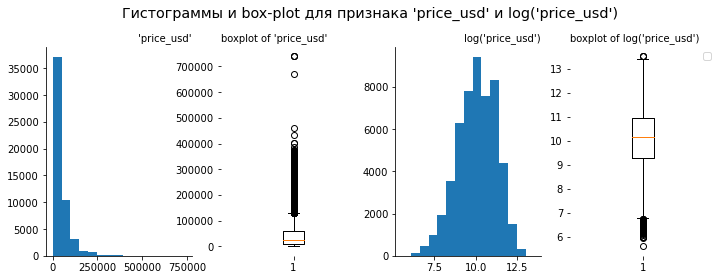

In [98]:
plot_column_info_log(data.query('sample == 1'), 'price_usd')

In [99]:
# Выносим в блок предобработки

# Возьмем логарифм от целевого признака
data.loc[:, 'price_log'] = np.log(data['price'] + 1)
data.loc[:, 'price_usd_log'] = np.log(data['price_usd'] + 1)

# определим все 4 признака к целевым
target_cols += ['price', 'price_usd', 'price_log', 'price_usd_log']

In [100]:
display(data.columns)
len(data.columns)

Index(['body_type', 'brand', 'color', 'fuel_type', 'mileage', 'model_date',
       'name', 'number_of_doors', 'engine_power', 'wheel', 'drive_type', 'pts',
       'owners', 'vehicle_transmission', 'production_date', 'vendor',
       'model_name', 'engine_displacement', 'ownership', 'complectation_dict',
       'equipment_dict', 'parsing_unixtime', 'price', 'sample', 'pts_isnan',
       'is_new', 'owners_isnan', 'usd_rub_rate_date', 'price_usd', 'price_log',
       'price_usd_log'],
      dtype='object')

31

In [101]:
display(time_cols)
display(bin_cols)
display(cat_cols)
display(num_cols)
display(del_cols)
len(time_cols + bin_cols + cat_cols + num_cols + del_cols + ['price', 'price_usd', 'sample'])

['parsing_unixtime']

['pts_isnan', 'pts', 'is_new', 'wheel', 'owners_isnan', 'vendor']

['body_type',
 'brand',
 'color',
 'fuel_type',
 'drive_type',
 'vehicle_transmission',
 'model_name']

['mileage',
 'model_date',
 'number_of_doors',
 'engine_power',
 'owners',
 'production_date',
 'engine_displacement']

['name',
 'ownership',
 'complectation_dict',
 'equipment_dict',
 'usd_rub_rate_date']

29

In [102]:
# Выведем информацию после изменений
data_full_info(data[cat_cols + bin_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,body_type,object,87319,0,94,лифтбек,лифтбек,лифтбек
1,brand,object,87319,0,12,SKODA,SKODA,SKODA
2,color,object,87319,0,16,синий,чёрный,серый
3,fuel_type,object,87319,0,5,бензин,бензин,бензин
4,drive_type,object,87319,0,3,передний,передний,передний
5,vehicle_transmission,object,87319,0,4,ROBOT,MECHANICAL,ROBOT
6,model_name,object,87319,0,544,OCTAVIA,OCTAVIA,SUPERB
7,pts_isnan,uint8,87319,0,2,0,0,0
8,pts,int64,87319,0,2,1,1,1
9,is_new,int64,87319,0,2,0,0,0


In [103]:
# Выведем информацию после изменений
data_full_info(data[num_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,mileage,float64,87319,0,21957,11.2118,11.0115,11.3851
1,model_date,float64,87319,0,67,2013,2017,2013
2,number_of_doors,float64,87319,0,5,5,5,5
3,engine_power,float64,87319,0,331,4.66344,4.70953,5.03044
4,owners,float64,87319,0,4,3,1,1
5,production_date,int64,87319,0,71,2014,2017,2014
6,engine_displacement,float64,87319,0,55,0.788457,0.955511,1.02962


In [104]:
def clear_and_prepare_data(data_in: pd.DataFrame) -> pd.DataFrame:
    # Создадим в блок предобработки
    
    data = data_in.copy()
    
    # Данный объект имеет очень много пропусков, в том числе и в полях model_date, name, number_of_doors, engine_power, drive_type, vehicle_transmission
    # Удалим его
    data = data.dropna(subset=['body_type'])
    # Приведем значения признака body_type к нижнему регистру
    data.loc[:, 'body_type'] = data['body_type'].apply(lambda x: str(x).lower())

    # Есть пустые значения. Заполняем пустые значения самым распространенным значением
    data = replace_nan(data, 'pts', 'mode')
    # Преобразуем education в целочисленный формат. 
    pts_dict = {'ORIGINAL': 1, 'DUPLICATE': 0}
    data.loc[:, 'pts'] = data['pts'].map(pts_dict)

    # Возьмем логарифм от признака
    data.loc[:, 'mileage'] = np.log(data['mileage'] + 1)
    # Добавим новый признак 'is_new' Новая машина или б/у
    data.loc[:, 'is_new'] = data['mileage'].apply(lambda x: 0 if x > 0 else 1)

    # приведем к формату int
    data.loc[:, 'engine_power'] = data['engine_power'].astype('int')
    # Возьмем логарифм от признака
    data.loc[:, 'engine_power'] = np.log(data['engine_power'] + 1)

    # Преобразуем wheel в целочисленный формат. 
    wheel_dict = {'LEFT': 1, 'RIGHT': 0}
    data.loc[:, 'wheel'] = data['wheel'].map(wheel_dict)

    # Заполним пропуски в поле owners 0, если проьег нулевой.
    data.loc[data.query('owners != owners and mileage == 0').index, 'owners'] = 0
    # Заполним пропуски в поле owners медианным значением
    data = replace_nan(data, 'owners', 'median')

    # Поправим значение признака на 'EUROPEAN'
    index = data.query('vendor == "AMERICAN"').index
    data.loc[index, 'vendor'] = 'EUROPEAN'
    # Преобразуем vendor в целочисленный формат. 
    vendor_dict = {'EUROPEAN': 1, 'JAPANESE': 0}
    data.loc[:, 'vendor'] = data['vendor'].map(vendor_dict)

    # Возьмем логарифм от признака
    data.loc[:, 'engine_displacement'] = np.log(data['engine_displacement'] + 1)

    # Пустых значений нет. Переведем в формат времени
    data.loc[:, 'parsing_unixtime'] = data['parsing_unixtime'].apply(lambda x: datetime.fromtimestamp(x))

    # Добавим новый признак 'usd_rub_rate_date' - курс доллара к рублю на момент выгрузки данных
    usd_rub_rate_date = {
        '10.07.2021': 74.4675, '26.10.2020': 76.4667, '25.10.2020': 76.4667,
        '24.10.2020': 76.4667, '21.10.2020': 77.7780, '20.10.2020': 77.9241, '19.10.2020': 77.9644
    }
    data.loc[:, 'usd_rub_rate_date'] = data['parsing_unixtime'].dt.strftime('%d.%m.%Y').map(usd_rub_rate_date)

    # Заполним пустые значения медианным значение для данной марки
    index_nan_price = data.query('sample == 1 and price != price').index
    median_price_model = data.query('sample == 1 and price == price').groupby('model_name')['price'].median()
    data.loc[index_nan_price, 'price'] = data.loc[index_nan_price, 'model_name'].map(median_price_model)

    # Добавим пцелевой ризнак в валюте usd
    data.loc[:, 'price_usd'] = data['price'] / data['usd_rub_rate_date']
    # Возьмем логарифм от целевого признака
    data.loc[:, 'price_log'] = np.log(data['price'] + 1)
    data.loc[:, 'price_usd_log'] = np.log(data['price_usd'] + 1)
    
    return data

In [105]:
# Загрузим данные
train, test, sample_submission = load_data_frames()

# Согласуем наименования признаков
rename_columns_train(train)
rename_columns_test(test)

# Согласуем форматы признаков
prepare_columns_format_train(train)
prepare_columns_format_test(test)

# Объединим датасеты в один
data = concatenate_data_frames(train, test)

# Почистим и подготовим датасет
data = clear_and_prepare_data(data)

В новый признак 'pts_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака pts самым распространенным значением  ORIGINAL
В новый признак 'owners_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака owners медианой 2.0


In [106]:
# Выведем информацию после изменений
data_full_info(data[cat_cols + bin_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,body_type,object,87319,0,94,лифтбек,лифтбек,лифтбек
1,brand,object,87319,0,12,SKODA,SKODA,SKODA
2,color,object,87319,0,16,синий,чёрный,серый
3,fuel_type,object,87319,0,5,бензин,бензин,бензин
4,drive_type,object,87319,0,3,передний,передний,передний
5,vehicle_transmission,object,87319,0,4,ROBOT,MECHANICAL,ROBOT
6,model_name,object,87319,0,544,OCTAVIA,OCTAVIA,SUPERB
7,pts_isnan,uint8,87319,0,2,0,0,0
8,pts,int64,87319,0,2,1,1,1
9,is_new,int64,87319,0,2,0,0,0


In [107]:
# Выведем информацию после изменений
data_full_info(data[num_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,mileage,float64,87319,0,21957,11.2118,11.0115,11.3851
1,model_date,float64,87319,0,67,2013,2017,2013
2,number_of_doors,float64,87319,0,5,5,5,5
3,engine_power,float64,87319,0,331,4.66344,4.70953,5.03044
4,owners,float64,87319,0,4,3,1,1
5,production_date,int64,87319,0,71,2014,2017,2014
6,engine_displacement,float64,87319,0,55,0.788457,0.955511,1.02962


## Оценка корреляций

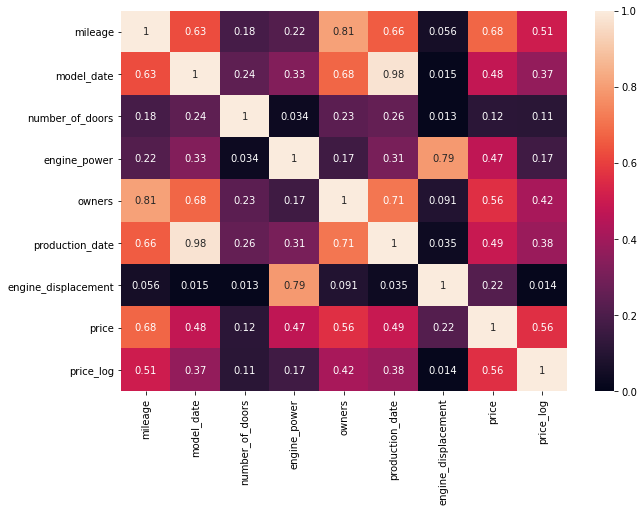

In [108]:
# Оценим корреляцию Пирсона для непрерывных переменных 
plt.figure(figsize = (10,7))
data_corr = data[num_cols + ['price','price_log']].corr().abs()
sns.heatmap(data_corr, vmin=0, vmax=1, annot=True)

In [109]:
pd.DataFrame(data_corr['price_log'].sort_values(ascending=False))

,price_log
price_log,1.000000
price,0.564468
mileage,0.505337
owners,0.417041
production_date,0.384837
model_date,0.369287
engine_power,0.171295
number_of_doors,0.109700
engine_displacement,0.013614


**Выводы по матрице корелляции** 

C целевым признаком выше всего скоррелированы (по убыванию):
 - mileage (пробег)
 - owners (кол-во)
 - production_date (дата производства)
 - model_date (дата выхода модели)
 - engine_power (мощность авто л.с.)
 - number_of_doors (количество дверей)
 - engine_displacement (объем двигателя)

в датасете присутствует сильная корреляция (0.98) признаков production_date и model_date, что в целом логично. Один из признаков можно убрать.

Также можно заметить большую корреляцию между engine_power и engine_displacement, это объяснимо, ведь чем больше объем двигателя, тем больше его мощьность, если рассматривать двигатели примерно одно класса (год, наличие турбин и т.д.). Еще mileage, owners и model_date тоже хорошо скоррелированны, чем старше авто, тем веше пробег и количество владельцев


In [110]:
# Выносим в блок предобработки

#Удаляем лишний признак model_date
del_cols.append('model_date')
num_cols.remove('model_date')

## Посмотрим на значимость колличественных переменных
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

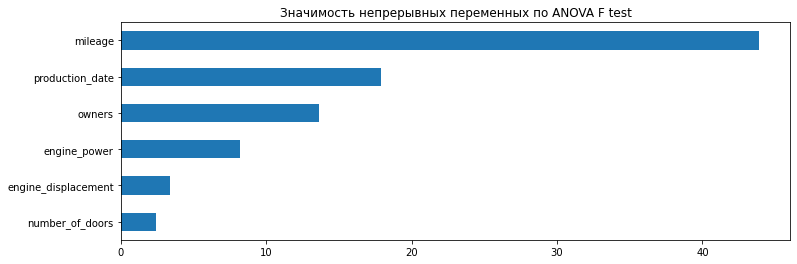

In [111]:
df = data.query('sample == 1')
imp_num = pd.Series(f_classif(df[num_cols], df['price_log'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

**Выводы:**
- Самый значимый признак mileage
- Потом идут признаки production_date, owners  и engine_power
- Последние по значимости признаки - engine_displacement и number_of_doors

## Посмотрим на значимость категориальных и бинарных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [112]:
nom_cols = cat_cols + bin_cols
delete_cols = []

for col in nom_cols:
    if not get_stat_dif(data.query('sample == 1'), col, 'price_log'):
        delete_cols.append(col)
        
print('Признаки на удаление: ', delete_cols)

Найдены статистически значимые различия для признака body_type
Найдены статистически значимые различия для признака brand
Найдены статистически значимые различия для признака color
Найдены статистически значимые различия для признака fuel_type
Найдены статистически значимые различия для признака drive_type
Найдены статистически значимые различия для признака vehicle_transmission
Найдены статистически значимые различия для признака model_name
Найдены статистически значимые различия для признака pts_isnan
Найдены статистически значимые различия для признака pts
Найдены статистически значимые различия для признака is_new
Найдены статистически значимые различия для признака wheel
Найдены статистически значимые различия для признака owners_isnan
Найдены статистически значимые различия для признака vendor
Признаки на удаление:  []


**Выводы:**
- Статистически значимые различия присутствуют по всем признакам
- Кандидатов на удаления нет.

# 5. Data Preprocessing

Перед обучением регрессии необходимо сделать две вещи:

 - Стандартизировать числовые признаки
 - Применить Label Encoding подход к категориальным признакам
 - Сделать разбиение на тестовую и валидационную выборки

## Label Encoding для кактегориальных признаков

In [113]:
# применим подход Label Encoding для категориальных признаков
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

In [114]:
data.sample(4)

,body_type,brand,color,fuel_type,mileage,model_date,name,number_of_doors,engine_power,wheel,drive_type,pts,owners,vehicle_transmission,production_date,vendor,model_name,engine_displacement,ownership,complectation_dict,equipment_dict,parsing_unixtime,price,sample,pts_isnan,is_new,owners_isnan,usd_rub_rate_date,price_usd,price_log,price_usd_log
39576,2,1,12,0,12.154785,2006.0,30i 3.0 AT (272 л.с.) 4WD,5.0,5.609472,1,2,1,2.0,0,2009,1,524,1.386294,"{'year': 2015, 'month': 6}",{'id': '0'},"{'wheel-heat': True, 'tinted-glass': True, 'wh...",2021-07-10 02:07:27,1035000.0,1,0,0,0,74.4675,13898.680632,13.849913,9.539621
7161,58,11,15,0,12.601491,2004.0,2.4 AT (140 л.с.),4.0,4.948760,1,1,1,3.0,0,2007,1,405,1.223775,NaN,NaN,NaN,2020-10-21 00:05:23,0.0,0,0,0,0,77.7780,0.000000,0.000000,0.000000
40967,2,1,12,3,0.000000,2017.0,30d xDrive 3.0d AT (249 л.с.) 4WD,5.0,5.521461,1,2,1,0.0,0,2021,1,520,1.386294,NaN,"{'id': '21184800', 'name': 'xDrive30d', 'avail...","{'asr': True, 'esp': True, 'adaptive-light': T...",2021-07-10 02:07:27,5540000.0,1,0,1,0,74.4675,74394.870245,15.527505,11.217156
17743,58,5,12,0,11.198228,2016.0,200 2.0 AT (184 л.с.),4.0,5.220356,1,0,1,2.0,0,2016,1,177,1.098612,NaN,NaN,NaN,2020-10-21 02:56:20,0.0,0,0,0,0,77.7780,0.000000,0.000000,0.000000


## Стандартизируем числовые переменные:

In [115]:
# Стандартизация числовых переменных
scaler = StandardScaler()

index = data.query('sample == 1')[num_cols].index
values_income = data.query('sample == 1')[num_cols].values
values_norm = scaler.fit_transform(values_income)
data.loc[index, num_cols] = values_norm

index = data.query('sample == 0')[num_cols].index
values_income = data.query('sample == 0')[num_cols].values
values_norm = scaler.transform(values_income)
data.loc[index, num_cols] = values_norm

## Подготовка выборок

In [116]:
X = data.query('sample == 1').drop(columns=time_cols + del_cols + ['price','price_usd','usd_rub_rate_date'])
X_sub = data.query('sample == 0').drop(columns=time_cols + del_cols + ['price','price_usd','usd_rub_rate_date'])

y = data.query('sample == 1')['price_usd'].values

In [117]:
def get_columns():
    time_cols = ['parsing_unixtime']
    bin_cols = ['pts_isnan', 'pts', 'is_new', 'wheel', 'owners_isnan', 'vendor']
    cat_cols = [
        'body_type', 'brand', 'color', 'fuel_type',
        'drive_type', 'vehicle_transmission', 'model_name'
    ]
    num_cols = [
        'mileage', 'number_of_doors', 'engine_power',
        'owners', 'production_date', 'engine_displacement']
    del_cols = [
        'name', 'ownership', 'complectation_dict',
        'equipment_dict', 'usd_rub_rate_date', 'model_date'
    ]
    target_cols = ['price','price_usd','price_log','price_usd_log']
    
    return time_cols, bin_cols, cat_cols, num_cols, del_cols, target_cols

In [118]:
def prepare_data_before_split(data_in: pd.DataFrame, column_target: str) -> pd.DataFrame:
    # Объединим подготовку в один модуль
    data = data_in.copy()
    time_cols, bin_cols, cat_cols, num_cols, del_cols, target_cols = get_columns()
    
    # применим подход Label Encoding для категориальных признаков
    for colum in cat_cols:
        data[colum] = data[colum].astype('category').cat.codes
        
    # Стандартизация числовых переменных
    scaler = StandardScaler()

    index = data.query('sample == 1')[num_cols].index
    values_income = data.query('sample == 1')[num_cols].values
    values_norm = scaler.fit_transform(values_income)
    data.loc[index, num_cols] = values_norm

    index = data.query('sample == 0')[num_cols].index
    values_income = data.query('sample == 0')[num_cols].values
    values_norm = scaler.transform(values_income)
    data.loc[index, num_cols] = values_norm
    
    #
    X = data.query('sample == 1').drop(columns=time_cols + del_cols + target_cols + ['sample'])
    X_sub = data.query('sample == 0').drop(columns=time_cols + del_cols + target_cols + ['sample'])
    y = data.query('sample == 1')[column_target]
    
    return X, X_sub, y

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 6. Model

Загрузим и подготовим все данные снуля

In [120]:
# Загрузим данные
train, test, sample_submission = load_data_frames()

# Согласуем наименования признаков
rename_columns_train(train)
rename_columns_test(test)

# Согласуем форматы признаков
prepare_columns_format_train(train)
prepare_columns_format_test(test)

# Объединим датасеты в один
data = concatenate_data_frames(train, test)

# Почистим и подготовим датасет
data = clear_and_prepare_data(data)

# сделаем предобработку
X, X_sub, y = prepare_data_before_split(data, 'price_log')

# Разобъем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

В новый признак 'pts_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака pts самым распространенным значением  ORIGINAL
В новый признак 'owners_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака owners медианой 2.0


## CatBoost

У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

In [121]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [122]:
# Получим предсказанные значения для валидации модели
y_true = y_test
predict_test = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_true, predict_test))*100:0.2f}%")
print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_true) - 1, np.exp(predict_test) - 1))*100:0.2f}%")

Точность модели по метрике MAPE: 0.79%
Точность модели по метрике MAPE если перевести в валюту: 11.20%


In [123]:
# Получим предсказанные значения submission
predict_submission = np.exp(model.predict(X_sub)) - 1

# В качестве целевой переменной мы использовали цену в долларах. Надо перевести предсказанные значения submission обратно в рубли
#usd_rub_rate_submission = data.query('sample == 0')['usd_rub_rate_date'].values
#predict_submission = np.round(predict_submission * usd_rub_rate_submission, 2)


Посмотрим на кроссвалидацию по этой модели

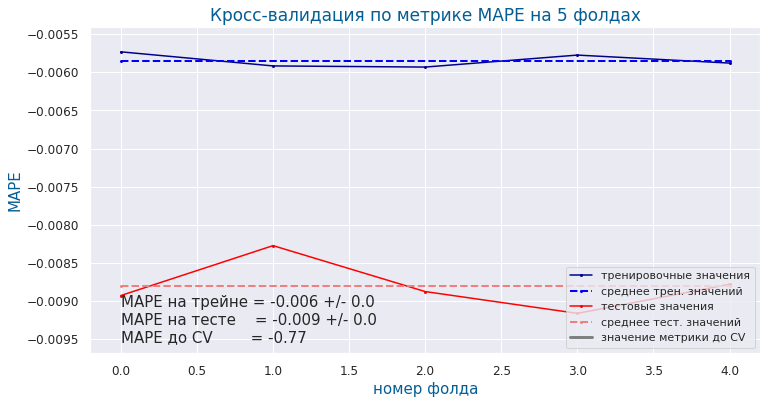

In [124]:
score = make_scorer(mape, greater_is_better=False)

cv_metrics = cross_validate(model, X_test, y_test, cv=5, scoring=score, return_train_score=True)

vis_cross_val_score('MAPE', cv_metrics, -0.77, 1.1)

 ## Тест различных моделей 
 
Попробуем различные модели

### 1. RandomForestRegressor

In [125]:
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_true, y_pred))*100:0.2f}%")
print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_true) - 1, np.exp(y_pred) - 1))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Точность модели по метрике MAPE: 0.83%
Точность модели по метрике MAPE если перевести в валюту: 11.64%


**Резюме:** мы получили МАРЕ = 11.64, это в районе baseline - CatBoostRegressor, что достаточно хорошо. Не будем пока тут уделять внимание округлению.


### 2. LinearRegression

In [126]:
model = LinearRegression()
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_true, y_pred))*100:0.2f}%")
print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_true) - 1, np.exp(y_pred) - 1))*100:0.2f}%")

Точность модели по метрике MAPE: 1.76%
Точность модели по метрике MAPE если перевести в валюту: 25.67%


**Резюме:** мы получили МАРЕ = 25.67, это в почти в 2 раза выше случайного леса. Можно попробовать подобрать оптимальные параметры для данной моедли, чтобы снизить метрику.



### 3. ExtraTreeRegressor

In [127]:
model = ExtraTreeRegressor(random_state = RANDOM_SEED)
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_true, y_pred))*100:0.2f}%")
print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_true) - 1, np.exp(y_pred) - 1))*100:0.2f}%")

Точность модели по метрике MAPE: 1.15%
Точность модели по метрике MAPE если перевести в валюту: 17.04%


**Резюме:** мы получили МАРЕ = 17.04, это лучше линейной регрессии. Но пока случайный лес показывает лучший результат.

### 4. GradientBoostingRegressor

In [128]:
# проверим градиентный бустинг 
model = GradientBoostingRegressor(n_estimators=250)
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_true, y_pred))*100:0.2f}%")
print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_true) - 1, np.exp(y_pred) - 1))*100:0.2f}%")

Точность модели по метрике MAPE: 0.99%
Точность модели по метрике MAPE если перевести в валюту: 14.12%


**Резюме:** мы получили МАРЕ = 14.13, результат еще улучшился. Но случайный лес все еще показывает лучший результат.

### 5. Bagging на RandomForestRegressor

In [129]:
# проверим BaggingRegressor вместе со случайным лесом на всем трейне
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model = BaggingRegressor(rf, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_true, y_pred))*100:0.2f}%")
print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_true) - 1, np.exp(y_pred) - 1))*100:0.2f}%")

Точность модели по метрике MAPE: 0.83%
Точность модели по метрике MAPE если перевести в валюту: 11.73%


Сравним с просто RandomForestRegressor

In [130]:
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_true, y_pred))*100:0.2f}%")
print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_true) - 1, np.exp(y_pred) - 1))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Точность модели по метрике MAPE: 0.83%
Точность модели по метрике MAPE если перевести в валюту: 11.64%


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


**Резюме:** Случайный лес без Бэгинга (МАРЕ = 11.64) оказался лучше чем с Бэгингом (МАРЕ = 11.73). Надо учитавыть, что это без настройки параметров.

### 6. Стеккинг на RandomForestRegressor и BaggingRegressor 

Для реализацции стеккинга определим функции:

In [131]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    
    print(f"Точность модели по метрике MAPE: {(mape(y_test, y_test_pred))*100:0.2f}%")
    print(f"Точность модели по метрике MAPE если перевести в валюту: {(mape(np.exp(y_test) - 1, np.exp(y_test_pred) - 1))*100:0.2f}%")

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    X_meta_train = np.zeros((len(y_train)), dtype=np.float32)

    splits = cv.split(X_train, y_train) 
    index = X_train.index
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train.loc[index[train_fold_index]], X_train.loc[index[predict_fold_index]]
        y_fold_train = y_train.loc[index[train_fold_index]]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict(X_test)
    
    return X_meta_train.reshape(len(X_meta_train), 1), X_meta_test.reshape(len(X_meta_test), 1)

In [132]:
RANDOM_STATE = 42

classifiers = [ 
    RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1),
    BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)
]

meta_classifier = LinearRegression()

In [133]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parall

In [134]:
compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

Точность модели по метрике MAPE: 0.82%
Точность модели по метрике MAPE если перевести в валюту: 11.54%


***Резюме*** Стеккинг показал самый лучший результат - МАРЕ = 11.53.

### 7. Сделаем подбор параметров для RandomForestRegressor

Попробуем подбирать разные значения для некоторых параметров. Для перебора вариантов возьмем следующие параметры:

 - n_estimators 
 - max_features 
 - max_depth 
 - min_samples_split 
 - min_samples_leaf
 - bootstrap

Мы можем сами указать, какие значения гиперпараметров надо перебрать.

In [135]:
def find_best_params(X_train, y_train):
    '''Функция для нахождения лучших гиперпараметров для модели.'''
    
    # Зададим сетку гиперпараметров, которые будут перебираться:
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
    max_depth.append(None)
    min_samples_split = [2] #, 5, 10]
    min_samples_leaf = [1]  #, 2, 4]
    bootstrap = [True]      #, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Обучим наш лес:
    rf = RandomForestRegressor(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, 
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)

    # View best hyperparameters
    print('Оптимальные гиперпараметры:\n')
    print(rf_random.best_params_)
    
    return rf_random.best_params_

In [136]:
# запустим поиск гиперпаметров
# best_params = find_best_params(X_train, y_train)

**Резюме:** Поиск гиперпараметров не удалось осуществить. Kaggle обрывает сессию. Попробовал уменьшить сетку - тоже ничего не вышло. Надо будет посотреть разные варианты

**В итоге** лучший результат был получен на модели CatBoostRegressor. Этот результат и отправим на проверку в соревновании на Kaggle.

# Submission

In [137]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.562187e+05
1,1100549428,1.011719e+06
2,1100658222,1.056774e+06
3,1100937408,7.956625e+05
4,1101037972,8.610668e+05
5,1100912634,8.435558e+05
6,1101228730,7.487807e+05
7,1100165896,4.392823e+05
8,1100768262,2.188347e+06
9,1101218501,8.785228e+05


# 7. Итог:

1. Была написана программа по сбору данных с сайта auto.ru
2. Был подготовлен набор данных для обучения последующих алгоритмов

3. В результате работы над данными:
 - был произведен разведывательный анализ данных
 - созданы новые признаки
 - отбраны признаки для модели по значимости
 - проведена проверка различных моделей, в частности  был посторен стеккинг на RandomForestRegressor и BaggingRegressor

4. В финальной версии модели score - 10.85 (на валидации) и 19.34834 (Public Score на Kaggle)